# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [75]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import sagemaker
from sagemaker import get_execution_role
import subprocess
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math




# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Setup Sagemaker Session
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
execution_role = sagemaker.session.get_execution_role()
region = sagemaker_session.boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
#download data to notebook
#define data location constants
local_data_dir = 'data'
s3_data_path = f's3://{bucket}/data' 
s3_model_path = f's3://{bucket}/model'

## Initial Model and Kaggle Submission

Below I will be setting up the an initial AutoGluon run without any refienment of the data. Then I'll be submitting to Kaggle.

In [4]:
%%capture

!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon #--no-cache-dir
!pip install kaggle
!pip install python-dotenv
from autogluon.tabular import TabularPredictor


### Setting up Kaggle Creds


In [12]:
!mkdir -p kaggle
!touch kaggle/kaggle.json
!chmod 600 kaggle/kaggle.json

env: KAGGLE_CONFIG_DIR=kaggle


In [162]:
%env KAGGLE_CONFIG_DIR=kaggle

env: KAGGLE_CONFIG_DIR=kaggle


In [171]:
from dotenv import dotenv_values

CONFIG = dotenv_values('env.txt')
kaggle_username = CONFIG['KAGGLE_USERNAME']
kaggle_key = CONFIG['KAGGLE_KEY']

# Save API token the kaggle.json file
with open("kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Downloading and Prepping Data

In [112]:
train_data = pd.read_csv(f'{s3_data_path}/train.csv')

/tmp/ipykernel_7054/3792393069.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(f'{s3_data_path}/train.csv')


In [113]:
train_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [114]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [115]:
train_data.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


#### First Submission
To start for our first submission we're going to drop all the columns but the ones explored in the proposal section, this is simply to get a basic submission and baseline to compare against at the end of the project.

#### Drop Columns, DropNA, Normalize

In [116]:
train_data[['LNR', 'RESPONSE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'ANREDE_KZ']].describe()

,LNR,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ
count,42962.000000,42962.000000,42357.000000,42357.000000,42357.000000,42962.000000
mean,42803.120129,0.012383,17.661071,5.274996,5.927001,1.595084
std,24778.339984,0.110589,14.085702,4.470538,3.398336,0.490881
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,21284.250000,0.000000,6.000000,2.000000,3.000000,1.000000
50%,42710.000000,0.000000,15.000000,4.000000,5.000000,2.000000
75%,64340.500000,0.000000,32.000000,10.000000,9.000000,2.000000
max,85795.000000,1.000000,40.000000,12.000000,10.000000,2.000000


In [117]:
#Select Columns
selected_columns = ['RESPONSE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'ANREDE_KZ']
init_train = train_data[selected_columns]

#DropNA
features = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'ANREDE_KZ']
init_train = init_train.dropna(subset=features).copy()

# Normalize key values
scaler = StandardScaler()
columns_to_normalize = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN']
init_train[columns_to_normalize] = scaler.fit_transform(init_train[columns_to_normalize])

#categorize sex
init_train['ANREDE_KZ'] = init_train['ANREDE_KZ'].map({1: 'Male', 2: 'Female'}).astype('category')

#categorize target
init_train['RESPONSE'] = init_train['RESPONSE'].map({0: 'NOPURCHASE', 1: 'PURCHASE'}).astype('category')

In [118]:
init_train.head()

,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ
0,NOPURCHASE,-0.685886,-0.732582,-0.861314,Female
1,NOPURCHASE,0.095057,-0.061514,0.904276,Female
2,NOPURCHASE,-1.253845,-1.179960,1.198541,Male
3,NOPURCHASE,-0.117927,-0.285203,-0.861314,Female
4,NOPURCHASE,-0.614891,-0.508892,0.021481,Male


In [119]:
init_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42357 entries, 0 to 42961
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   RESPONSE             42357 non-null  category
 1   LP_LEBENSPHASE_FEIN  42357 non-null  float64 
 2   LP_LEBENSPHASE_GROB  42357 non-null  float64 
 3   LP_STATUS_FEIN       42357 non-null  float64 
 4   ANREDE_KZ            42357 non-null  category
dtypes: category(2), float64(3)
memory usage: 1.4 MB


In [120]:
init_train.describe()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN
count,4.235700e+04,4.235700e+04,4.235700e+04
mean,-1.087026e-16,6.106135e-17,4.579601e-17
std,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.253845e+00,-1.179960e+00,-1.449845e+00
25%,-8.278756e-01,-7.325817e-01,-8.613144e-01
50%,-1.889223e-01,-2.852030e-01,-2.727842e-01
75%,1.017990e+00,1.056933e+00,9.042763e-01
max,1.585948e+00,1.504312e+00,1.198541e+00


#### Create Weights

<Axes: >

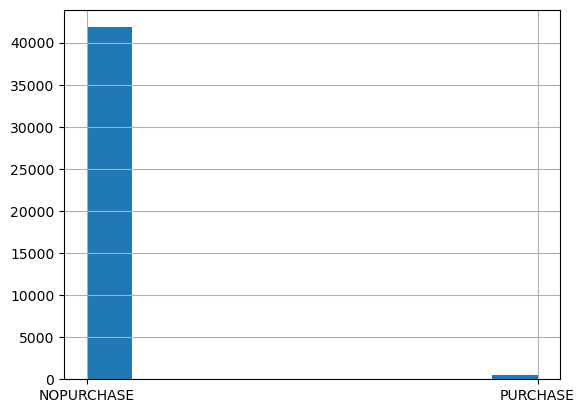

In [121]:
init_train['RESPONSE'].hist()

In [122]:
#Get Buyers
purchase_records = init_train[init_train['RESPONSE'] == 'PURCHASE']
#Get NonBuyer Records
no_purchase_records = init_train[init_train['RESPONSE'] == 'NOPURCHASE']

buyer_weight_multiplier = math.floor(len(no_purchase_records) / len(purchase_records))
print(f'buyer_weight_multiplier: {buyer_weight_multiplier}')
init_train['RECORD_WEIGHT'] = np.where(init_train.index.isin(purchase_records.index), buyer_weight_multiplier, 1)

buyer_weight_multiplier: 79


In [123]:
init_train.head()

,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ,RECORD_WEIGHT
0,NOPURCHASE,-0.685886,-0.732582,-0.861314,Female,1
1,NOPURCHASE,0.095057,-0.061514,0.904276,Female,1
2,NOPURCHASE,-1.253845,-1.179960,1.198541,Male,1
3,NOPURCHASE,-0.117927,-0.285203,-0.861314,Female,1
4,NOPURCHASE,-0.614891,-0.508892,0.021481,Male,1


In [124]:
init_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42357 entries, 0 to 42961
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   RESPONSE             42357 non-null  category
 1   LP_LEBENSPHASE_FEIN  42357 non-null  float64 
 2   LP_LEBENSPHASE_GROB  42357 non-null  float64 
 3   LP_STATUS_FEIN       42357 non-null  float64 
 4   ANREDE_KZ            42357 non-null  category
 5   RECORD_WEIGHT        42357 non-null  int64   
dtypes: category(2), float64(3), int64(1)
memory usage: 1.7 MB


In [125]:
init_train.describe()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,RECORD_WEIGHT
count,4.235700e+04,4.235700e+04,4.235700e+04,42357.000000
mean,-1.087026e-16,6.106135e-17,4.579601e-17,1.970465
std,1.000012e+00,1.000012e+00,1.000012e+00,8.646170
min,-1.253845e+00,-1.179960e+00,-1.449845e+00,1.000000
25%,-8.278756e-01,-7.325817e-01,-8.613144e-01,1.000000
50%,-1.889223e-01,-2.852030e-01,-2.727842e-01,1.000000
75%,1.017990e+00,1.056933e+00,9.042763e-01,1.000000
max,1.585948e+00,1.504312e+00,1.198541e+00,79.000000


In [126]:
#Buyer Record Head
purchase_records_head = init_train[init_train['RESPONSE'] == 'PURCHASE']
purchase_records_head.head()

,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ,RECORD_WEIGHT
90,PURCHASE,1.585948,1.504312,1.198541,Female,79
129,PURCHASE,-0.614891,-0.508892,0.315746,Male,79
173,PURCHASE,1.514953,1.504312,1.198541,Male,79
205,PURCHASE,-0.117927,-0.285203,-0.861314,Male,79
248,PURCHASE,0.166052,-0.061514,1.198541,Male,79


### Doing Simple Training

In [127]:
# Normalize the weights
init_train['RECORD_WEIGHT'] /= init_train['RECORD_WEIGHT'].sum()
init_train['RECORD_WEIGHT'].describe()

count    42357.000000
mean         0.000024
std          0.000104
min          0.000012
25%          0.000012
50%          0.000012
75%          0.000012
max          0.000947
Name: RECORD_WEIGHT, dtype: float64

In [128]:
## Split Data into Training and Validation sets
init_train_data, init_valid_data = train_test_split(init_train, test_size=0.2, random_state=1)

In [129]:
predictor = TabularPredictor(label="RESPONSE", verbosity=4, sample_weight='RECORD_WEIGHT', weight_evaluation=True).fit(
    train_data=init_train_data,
    time_limit=600,
    presets="best_quality"
)

In [130]:
results = predictor.evaluate(init_valid_data)

In [131]:
results

{'accuracy': 0.5192922374429224,
 'balanced_accuracy': 0.5248097588352784,
 'mcc': 0.05102013171866195,
 'roc_auc': 0.5381529481191072,
 'f1': 0.4685764765270084,
 'precision': 0.5555056852184351,
 'recall': 0.40517241379310454}

In [132]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.546942    accuracy       0.439539   80.032187                0.065970          17.003350            2       True         13
1         LightGBMXT_BAG_L1   0.546836    accuracy       0.198783   22.908805                0.198783          22.908805            1       True          3
2           CatBoost_BAG_L1   0.544622    accuracy       0.063812   22.889361                0.063812          22.889361            1       True          7
3           LightGBM_BAG_L1   0.537115    accuracy       0.096161   21.718514                0.096161          21.718514            1       True          4
4     ExtraTreesEntr_BAG_L1   0.522239    accuracy       1.133869    2.390440                1.133869           2.390440            1       True          9
5 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.5076202174605342,
  'KNeighborsDist_BAG_L1': 0.5076202174605342,
  'LightGBMXT_BAG_L1': 0.546835903735044,
  'LightGBM_BAG_L1': 0.5371153875316561,
  'RandomForestGini_BAG_L1': 0.5222085740715469,
  'RandomF

In [133]:
model_path = predictor.path
print(f"The model was saved in: {model_path}")

The model was saved in: AutogluonModels/ag-20231202_165959


### Create Submission File and Submit

In [136]:
## Make copy of test file for submission
test_data = pd.read_csv(f'{s3_data_path}/test.csv')

/tmp/ipykernel_7054/9532272.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(f'{s3_data_path}/test.csv')


#### Transform Features

In [137]:
## Get Neccisary Columns
init_test_columns = [col for col in selected_columns if col != 'RESPONSE']
init_test = test_data[init_test_columns].copy()

## Need to fill in NA values
init_test.loc[:, 'LP_LEBENSPHASE_FEIN'] = init_test['LP_LEBENSPHASE_FEIN'].fillna(init_test['LP_LEBENSPHASE_FEIN'].mean())
init_test.loc[:, 'LP_LEBENSPHASE_GROB'] = init_test['LP_LEBENSPHASE_GROB'].fillna(init_test['LP_LEBENSPHASE_GROB'].mean())
init_test.loc[:, 'LP_STATUS_FEIN'] = init_test['LP_STATUS_FEIN'].fillna(init_test['LP_STATUS_FEIN'].mean())

# Use the same scaler from training data to normalize
init_test.loc[:, columns_to_normalize] = scaler.transform(init_test[columns_to_normalize])

#categorize the same as training data
init_test.loc[:, 'ANREDE_KZ'] = init_test['ANREDE_KZ'].map({1: 'Male', 2: 'Female'}).astype('category')

In [138]:
init_test.head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ
0,0.166052,-0.061514,1.198541,Male
1,-0.827876,-0.732582,-1.449845,Male
2,1.585948,1.504312,1.198541,Female
3,-1.253845,-1.179960,-0.861314,Female
4,1.372964,1.504312,0.904276,Female


In [139]:
init_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   LP_LEBENSPHASE_FEIN  42833 non-null  float64 
 1   LP_LEBENSPHASE_GROB  42833 non-null  float64 
 2   LP_STATUS_FEIN       42833 non-null  float64 
 3   ANREDE_KZ            42833 non-null  category
dtypes: category(1), float64(3)
memory usage: 1.0 MB


In [140]:
init_test.describe()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN
count,42833.000000,42833.000000,42833.000000
mean,0.008101,0.008544,0.002803
std,0.994011,0.994352,0.997370
min,-1.253845,-1.179960,-1.449845
25%,-0.827876,-0.732582,-0.861314
50%,-0.188922,-0.285203,0.002803
75%,1.017990,1.056933,0.904276
max,1.585948,1.504312,1.198541


In [141]:
predictions = predictor.predict(init_test)
predictions.describe()

count          42833
unique             2
top       NOPURCHASE
freq           27274
Name: RESPONSE, dtype: object

<Axes: >

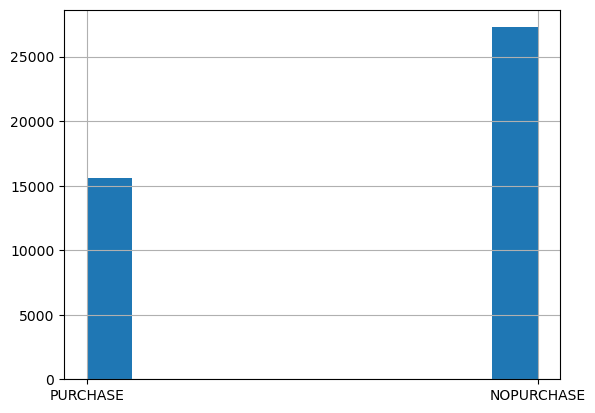

In [142]:
predictions.hist()

This proportion is perfect (or particularly close) but for the baseline submission I think this is fine

For sumbission file we to submit the probabilities of each record 

In [152]:
prediction_probabilities = predictor.predict_proba(init_test)
prediction_probabilities.head()

,NOPURCHASE,PURCHASE
0,0.450253,0.549747
1,0.470324,0.529676
2,0.517010,0.482990
3,0.546453,0.453547
4,0.508679,0.491321


In [155]:
prediction_probabilities['PURCHASE'].head()

0    0.549747
1    0.529676
2    0.482990
3    0.453547
4    0.491321
Name: PURCHASE, dtype: float64

In [157]:
submission_init = pd.DataFrame({'LNR': test_data['LNR'].copy(), 'RESPONSE': prediction_probabilities['PURCHASE']})

In [158]:
submission_init.to_csv("init_submission.csv", index=False)

In [172]:
!kaggle competitions submit -c udacity-arvato-identify-customers -f init_submission.csv -m "first raw submission"

403 - Forbidden - Permission 'competitions.participate' was denied
